In [1]:
%run mnist_basic_data.ipynb
%run mnist_basic_model.ipynb

Using TensorFlow backend.


In [2]:
from keras.models import load_model
from matplotlib import patches
import numpy as np

In [3]:
def transform_coord(coord, cell):
    cy = cell // GRID_SIZE
    cx = cell % GRID_SIZE
    w = coord[12] * screen[0]
    h = coord[13] * screen[1]
    x = (coord[10] + cx)*(screen[0] / GRID_SIZE ) - (w/2)
    y = (coord[11] + cy)*(screen[1] / GRID_SIZE ) - (h/2)
    return (x, y), w, h

In [68]:
def plot_results(batch_, pred):
    fig, axList = plt.subplots(2,4)
    fig.set_size_inches(12,8)
    
    batch = [0, 1]
    batch[0] = batch_[0]
    batch[1] = batch_[1].reshape(-1, GRID_SIZE * GRID_SIZE, 15)
    pred = pred.reshape(-1, GRID_SIZE * GRID_SIZE, 15)
    
    for i, ax in enumerate(axList.flatten()):
        ax.set_axis_off()
        ax.imshow(batch[0][i].reshape(86,86), cmap='gray')
        
        conf = pred[i][..., 14]
        sorted_ind = conf.argsort()
        top3_ind = sorted_ind[-3:]
        
#         title = ''
        for j in top3_ind:
#             title += str(pred[i][j][:10].argmax()) +':- '+ str(pred[i][j][:10].max() * pred[i][j][-1]) + ' ' if batch[1][i][j][:10].argmax() != pred[i][j][:10].argmax() else str('ok ')
            
            c1, c2, c3 = transform_coord(pred[i][j], j)
            rec = patches.Rectangle(c1, c2, c3, edgecolor='r', fill=False, linewidth=1)
            ax.add_patch(rec)
            ax.text(c1[0], c1[1]+6, str(pred[i][j][:10].argmax(axis=-1)), color='c', fontsize=12)
        
#         ax.set_title(title)
        true_conf = batch[1][i][..., 14]
        sorted_ind = true_conf.argsort()
        top3_ind = sorted_ind[-3:]
        
        for j in top3_ind:
            c1, c2, c3 = transform_coord(batch[1][i][j], j)
            rec = patches.Rectangle(c1, c2, c3, edgecolor='g', fill=False, linewidth=1)
            ax.add_patch(rec)

In [5]:
train, val, test = load_data()
x_test, y_test = test

test_gen = DataGenerator(x_test, y_test, batch_size=8)

model = load_model('mnist_basic_yolo.h5', compile=False)

In [6]:
model.compile('Adam', custom_loss, ['accuracy'])

In [70]:
batch = test_gen.gen_batch()
pred = model.predict(batch[0])

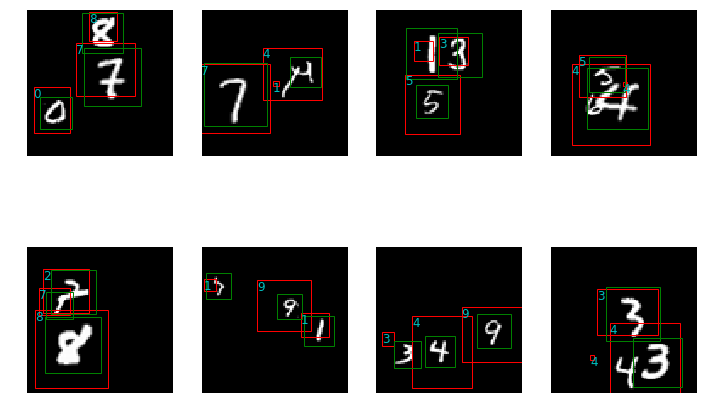

In [71]:
plot_results(batch, pred)

## Failures:

### Data Generation: Images
Couldn't find a way to remove black background in mnist images in PIL.
So, instead just used an np array.

### Data Generation: BBox
True Bounding boxes were totally incorrect because of confusing x-y axes and [y][x] indices

### Data Generation: BBox
Prediction were totally incorrect because each cell in the grid was predicting coordinates w.r.t to top-left corner of the image.

### Finally
By making coordinates inside a cell relative to top-left corner of each cell, results became appreciable. But mostly all predicted boxes are larger.

#### Still not using correct loss function, nor using multiple anchor boxes & non-max suppression
#### Don't know how to calculate mAP or any other metric (COCO).
#### Take a look at Focal Loss, Congenerous Cosine Loss, etc.
#### Try VAE for classification by reconstructing input and using sampled vector for classification